<a href="https://colab.research.google.com/github/mtzig/LIDC_GDRO/blob/main/notebooks/LIDC_Georges_End_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIDC GDRO: Looking at Clustered Subgroups

Thomas Zeng

## Notebook Setup

Setup autoreload extension

In [1]:
%load_ext autoreload
%autoreload 2

Clone repo (if on colab)

In [2]:
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd /content/LIDC_GDRO
# %cd ..

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 4066, done.
remote: Counting objects: 100% (638/638), done.
remote: Compressing objects: 100% (285/285), done.
remote: Total 4066 (delta 364), reused 620 (delta 352), pack-reused 3428
Receiving objects: 100% (4066/4066), 103.81 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (3512/3512), done.
Checking out files: 100% (5419/5419), done.
/content/LIDC_GDRO


In [41]:
# !git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/mtzig/LIDC_GDRO
   2f98872..2b9d560  main       -> origin/main
Updating 2f98872..2b9d560
Fast-forward
 utils/image_data_utils.py | 12 ++++++------
 1 file changed, 6 insertions(+), 6 deletions(-)


import necessary libraries

In [13]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import pandas as pd
import numpy as np
from dataloaders import InfiniteDataLoader
from datasets import SubclassedDataset
from models import TransferModel18
from train_eval import train, evaluate, train_epochs
from torch.optim.lr_scheduler import ReduceLROnPlateau
from loss import ERMLoss, GDROLoss 
import os
# import torchvision
from torchvision import transforms
import torch
from utils.image_data_utils import get_images, show_scatter

from umap import UMAP
from matplotlib import pyplot as plt
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

Get available Device

In [43]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Using cpu")
    DEVICE = torch.device("cpu")

Good to go!


## ERM Model: Training ERM model to extract CNN features

### ERM Modeling

Just for visulalization, the csv where we get the train, cv, test splits and subgroups come from below csv. 

In [38]:
df_splits = pd.read_csv('./data/train_test_splits/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spic_groups,malignancy,malignancy_b,split
1295,1,2,3,1,0
1400,2,3,3,1,0
1435,3,2,3,1,1
1066,4,2,2,1,0
1244,5,2,2,1,2


First we load in the training data

In [44]:
train_data, cv_data, test_data = get_images(split=True, sublabels='malignancy', binary=True, device=DEVICE)

#datasets
tr = SubclassedDataset(*train_data)
cv = SubclassedDataset(*cv_data)
tst = SubclassedDataset(*test_data)

#dataloaders
tr_loader = InfiniteDataLoader(tr, batch_size=512)
cv_loader = InfiniteDataLoader(cv, len(cv))
tst_loader = InfiniteDataLoader(tst, len(tst))

Next we initialize the model!

In [45]:
model = TransferModel18(device=DEVICE, pretrained=True, freeze=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.005)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Now we train the model

In [46]:
epochs = 15
loss_fn = ERMLoss(model, torch.nn.CrossEntropyLoss())
train_epochs(epochs, tr_loader, tst_loader, model, loss_fn, optimizer, verbose=True, num_subclasses=4)

Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15


In [47]:
evaluate(tst_loader,model, 4, verbose=True)

Accuracy: 0.840531561461794 
Accuracy over subgroups: [0.88235294 0.73451327 0.86111111 1.        ] 
Worst Group Accuracy: 0.7345132743362832


(0.840531561461794,
 0.8823529411764706,
 0.7345132743362832,
 0.8611111111111112,
 1.0)

### Feature Extraction

We first save model weights (for reproducibility)

In [ ]:
 torch.save(model.state_dict(), './data/erm_cluster_weights.pt')

Next we add hooks to let us get activations

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.model.avgpool.register_forward_hook(get_activation('avgpool'))

We re get the data, but in its entirety with the noduleID

In [ ]:
noduleID, data = get_images(split=False, binary=True, device=DEVICE)

Now we extract features

In [ ]:
imgs = torch.stack(data[0])
model(imgs)
img_features = activation['avgpool'].squeeze()

We collect all the features in a dataframe

In [ ]:
cols = []
for idx,id in enumerate(noduleID):
  cols.append([id] + img_features[idx].cpu().numpy().tolist())
df_features = pd.DataFrame(cols).rename({0:'noduleID'}, axis=1)

splits = [df_splits[df_splits['noduleID'] == id]['split'].iloc[0] for id in  df_features['noduleID']]
malig = [df_splits[df_splits['noduleID'] == id]['malignancy'].iloc[0] for id in  df_features['noduleID']]

df_features['split'] = splits
df_features['malignancy'] = malig
df_features['malignancy_b'] = np.where(df_features['malignancy']>1, 1, 0)
df_features.head()

We again save the data for reproducibility

In [ ]:
df_features.to_csv('./data/erm_cluster_cnn_features.csv')

## Feature Reduce and Cluster

### Feature Reduce

First we split df into two by the splits

In [ ]:
df_features_train = df_features[df_features['split'] == 0]
df_features_cv_test = df_features[df_features['split'] != 0]

Next we get the features in an array

In [ ]:
train_features = df_features_train.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values
cv_test_features = df_features_cv_test.drop(['noduleID', 'split', 'malignancy', 'malignancy_b'], axis=1).values

Following the George paper, we use UMAP to dimensionaly reduce our data

In [ ]:
reducer = UMAP(random_state=8)
reducer.fit(train_features)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


UMAP(random_state=8, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
train_embeds = reducer.transform(train_features)

Now we visualize the reduction on train dataset

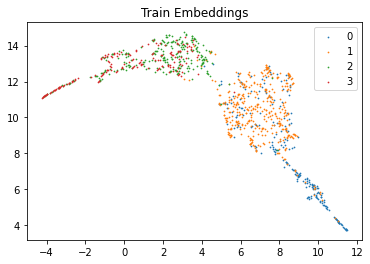

In [ ]:
show_scatter(train_embeds[:, 0], train_embeds[:, 1],df_features_train['malignancy'],'Train Embeddings', 0.5)



We also do same visualization on cv and test

In [ ]:
cv_test_embeds = reducer.transform(cv_test_features)

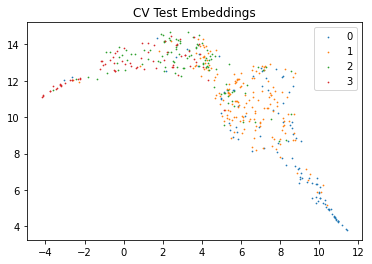

In [ ]:
show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],df_features_cv_test['malignancy'],'CV Test Embeddings', 0.5)


We now save the reduce

In [ ]:
f_reducer = './cnn_umap_reducer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))




Note to lode from above file, we can call
```python
reducer = pickle.load((open(f_reducer, 'rb'))) 
```

### Feature Cluster

Now we cluster the training embeddings using Gaussian Mixture

We first visualize the silhouette score

(we only cluster on malignant since that is what we want)

In [ ]:
train_embeds_malig = reducer.transform(train_features[df_features_train['malignancy_b'] == 1])

Text(0, 0.5, 'Silhouette Coefficients')

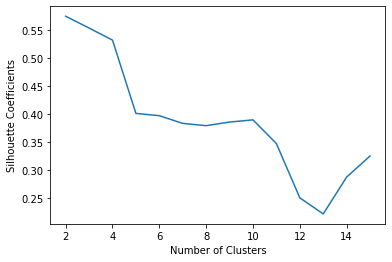

In [ ]:
clusters = [n for n in range(2,16)]
silhouette_coefficients = []

for cluster in clusters:
  gmm = GaussianMixture(n_components=cluster, random_state=61).fit(train_embeds_malig)
  labels = gmm.predict(train_embeds_malig)
  
  silhouette_avg = silhouette_score(train_embeds_malig, labels)
  silhouette_coefficients.append(silhouette_avg)

plt.plot(clusters, silhouette_coefficients)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficients')

We note from above, the best number of subclasses is 2.

In [ ]:
clusterer = GaussianMixture(n_components=2, random_state=61).fit(train_embeds_malig)

We now visualize the clusters ont train

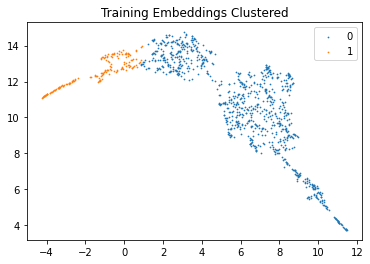

In [ ]:
train_labels = clusterer.predict(train_embeds)

show_scatter(train_embeds[:, 0], train_embeds[:, 1],train_labels,'Training Embeddings Clustered', 0.5)

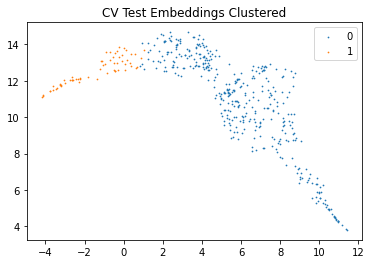

In [ ]:
cv_test_labels = clusterer.predict(cv_test_embeds)

show_scatter(cv_test_embeds[:, 0], cv_test_embeds[:, 1],cv_test_labels,'CV Test Embeddings Clustered', 0.5)

Now we save the clusterer

In [ ]:
f_clusterer = './cnn_umap_clusterer.sav'
pickle.dump(reducer, open(f_reducer, 'wb'))

### Save the labels

Now that we have the labels, we want to save them to csv we so we can train gDRO on them

In [ ]:
df_features_train['cluster'] = train_labels
df_features_cv_test['cluster'] = cv_test_labels

df_clusters = pd.concat([df_features_train, df_features_cv_test])[['noduleID', 'cluster']]
df_clusters.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,noduleID,clusters
2,1206,0
3,1902,0
4,2293,0
6,707,0
7,2180,0


In [ ]:
df_clusters = df_clusters.sort_values('noduleID')

We can add these lables to the df_splits dataframe

In [ ]:
df_splits['cluster'] = [ 0 if m % 2 == 0 else 1 + c for m,c in zip(df_splits['malignancy_b'], df_clusters['cluster'])]

In [ ]:
df_splits['cluster']

1295    2
1400    1
1435    2
1066    1
1244    1
       ..
1028    1
819     0
707     0
1436    1
501     0
Name: clusters, Length: 1488, dtype: int64

Now we save the csv

In [ ]:
df_splits.to_csv('./data/LIDC_data_split_with_cluster(temp).csv')

## Train ERM and gDRO on new models

We again get our dataloaders (but with the new sublables)

In [ ]:
df_splits = pd.read_csv('./data/LIDC_data_split.csv', index_col=0)
df_splits.head()

,noduleID,spic_groups,malignancy,malignancy_b,split,clusters
1295,1,2,3,1,0,2
1400,2,3,3,1,0,1
1435,3,2,3,1,1,2
1066,4,2,2,1,0,1
1244,5,2,2,1,2,1


In [ ]:
train_data_c, cv_data_c, test_data_c = get_images(split=True, sublabels='cluster', binary=True, device=DEVICE)

#datasets
tr_c = SubclassedDataset(*train_data_c)
cv_c = SubclassedDataset(*cv_data_c)
tst_c = SubclassedDataset(*test_data_c)

#dataloaders
tr_loader_c = InfiniteDataLoader(tr_c, batch_size=512)
cv_loader_c = InfiniteDataLoader(cv_c, len(cv_c))
tst_loader_c = InfiniteDataLoader(tst_c, len(tst_c))

### ERM

In [ ]:
model_ERM = TransferModel18(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
epochs = 15
loss_fn = ERMLoss(model, torch.nn.CrossEntropyLoss(), subclassed=True)
train_epochs(epochs, tr_loader_c, cv_loader_c, model_ERM, loss_fn=loss_fn, num_subgroups=3, scheduler=True, verbose=False)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-05.
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-06.
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-07.
Epoch 14/15
Epoch 15/15


In [ ]:
evaluate(tst_loader_c,model_ERM, 3)

(0.4219269102990033,
 0.055248618784530384,
 0.9761904761904762,
 0.9743589743589743)

### GDRO

In [ ]:
model_gDRO = TransferModel18(device=DEVICE, pretrained=True, freeze=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
epochs = 15
loss_fn = GDROLoss(model, torch.nn.CrossEntropyLoss(), 0.01, 3)

train_epochs(epochs, tr_loader_c, cv_loader_c, model_gDRO, loss_fn=loss_fn, num_subgroups=3, scheduler=True, verbose=True)

Epoch 1/15
Average training loss: 0.06460005864500999
Accuracy: 0.47619047619047616 
Accuracy over subgroups: [0.27777778 1.         0.76923077] 
Worst Group Accuracy: 0.2777777777777778
Epoch 2/15
Average training loss: 0.06385237090289593
Accuracy: 0.564625850340136 
Accuracy over subgroups: [0.38709677 1.         0.8627451 ] 
Worst Group Accuracy: 0.3870967741935484
Epoch 3/15
Average training loss: 0.06976257972419261
Accuracy: 0.5850340136054422 
Accuracy over subgroups: [0.4125     1.         0.75438596] 
Worst Group Accuracy: 0.4125
Epoch 4/15
Average training loss: 0.06530530080199241
Accuracy: 0.5850340136054422 
Accuracy over subgroups: [0.41573034 0.84615385 0.84444444] 
Worst Group Accuracy: 0.4157303370786517
Epoch 5/15
Average training loss: 0.06134747061878443
Accuracy: 0.6122448979591837 
Accuracy over subgroups: [0.43678161 1.         0.81818182] 
Worst Group Accuracy: 0.4367816091954023
Epoch 6/15
Average training loss: 0.08497328758239746
Accuracy: 0.6326530612244898

In [ ]:
evaluate(tst_loader_c,model_gDRO, 3)

(0.6112956810631229,
 0.47928994082840237,
 0.8444444444444444,
 0.7471264367816092)